# Procesamiento de Imagenes Satelitales Landsat 8 OLI LASRC

Las scenas **Landsat 8 OLI LASRC** tomadas en este trabajo, son imágenes pertenecientes a la Colección 1 - Nivel 2 (On demand) del catálogo de imagenes USGS Earth Explorer. Las imagenes del Nivel 2 presentan correcciones atmosfericas de reflectancia de superficie (Surface Reflectance SR). Estas correcciones mitigan el efecto de los gases o aerosoles que se encuentran en la atmosfera y pueden afectar la reflectancia de la tierra sensada por el satelite (sensor). Las correcciones atmosféricas son llevadas a cabo por el algoritmo LASRC (Landsat Surface Reflectance Code)

Durante la generación de las scenas corregidas en superficie de reflectancia, el algoritmo LASRC evalua la calidad de cada pixel y esta información la información de esta evaluación la registra en 3 bandas (**sr_aeroso**, **pixel_qa**, **radsat_qa**) que se generan de forma adicional al finalizar la corección de reflectancia.

El rango de valores que se pueden encontrar para cada pixel en las respectivas bandas son:

* band_1 (coastal_aerosol): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_2 (blue): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_3 (green): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_4 (red): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_5 (nir): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_6 (swir1): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_7 (swir2): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* pixel_qa (pixel_qa): rango=0,32768 rango_valido=0,32768 
* sr_aerosol (sr_aerosol_qa, aerosol_qa, aerosol): rango=0,255; rango_valido=0,255
* radsat_qa (radsat_qa): rango=0,32768 rango_valido=0,32768


## Referencias
1. [Designación de Bandas para Satelites Landsat](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products)
2. [Evaluación de la Calidad de los Pixeles en Landsat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8-surface-reflectance-quality-assessment?qt-science_support_page_related_con=1#qt-science_support_page_related_con)
3. [Lansat Surface Reflectance Code (LASRC) Product Guide](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf)

In [13]:
%matplotlib inline

import numpy as np
import xarray as xr
import rasterio as rio

import os
import glob
import tarfile
import shutil
import datacube

# Wofs imports
import gc
import collections

from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask

In [4]:
dc = datacube.Datacube(app="Query")

xarr = dc.load(
    product="LS8_OLI_LASRC",
    latitude=(4,5),
    longitude=(-78, -77), 
    # Time format YYYY-MM-DD
    time=("2018-01-01","2018-01-31"), 
    measurements=['blue','green','red','nir','swir1','swir2','pixel_qa']
)

xarr

<xarray.Dataset>
Dimensions:    (latitude: 3687, longitude: 3705, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-10T15:25:11
  * latitude   (latitude) float64 5.0 5.0 4.999 4.999 4.999 4.999 4.998 ...
  * longitude  (longitude) float64 -78.0 -78.0 -78.0 -78.0 -78.0 -78.0 -78.0 ...
Data variables:
    blue       (time, latitude, longitude) int16 297 299 301 301 299 305 311 ...
    green      (time, latitude, longitude) int16 162 157 156 159 159 168 168 ...
    red        (time, latitude, longitude) int16 65 66 66 64 63 71 74 75 71 ...
    nir        (time, latitude, longitude) int16 31 28 31 30 29 38 36 34 31 ...
    swir1      (time, latitude, longitude) int16 32 30 30 31 33 33 35 37 35 ...
    swir2      (time, latitude, longitude) int16 24 21 21 25 27 25 27 27 24 ...
    pixel_qa   (time, latitude, longitude) int32 324 324 324 324 324 324 324 ...
Attributes:
    crs:      EPSG:4326

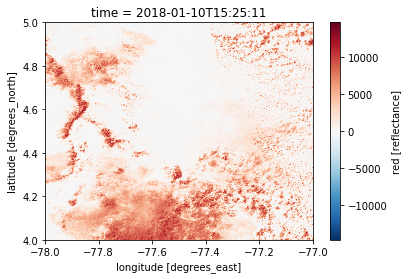

In [5]:
# Histograma de valores contenidos en el data array.
# xarr.red.plot.hist()
xarr.red.plot()

## Mascara de Nubes

Las nubes y las condiciones atmosféricas presentan un desafío importante cuando se trabaja con datos de detección remota multiespectrales. Las nubes y sombras extremas pueden generar datos initilizables. En principio las nubes dispersan toda la luz emitida por el sol haciendo que regrese al sensor sin datos relevantes. Por otro lado, puede sucede que la luz sea absorvida o bloqueada en este caso la cantidad de datos sensado de la superficie terrestre también es irrelavante.

Las imagenes landsat con corrección de reflectancia vienen con unas capas de calidad (**pixel_qa**) que permiten detectar la presencia de nubes, sombra e incluso agua en el monitoreo. Esta capa nos permitira identiicar y eliminar los pixeles que no son utiles para el analisis. En la siguiente tabla se muestra la representación de cada uno de los valores que se pueden en contrar para cada pixel de la banda o capa **pixel_qa**.


| Attribute                | Pixel Value                                                     |
|--------------------------|-----------------------------------------------------------------|
| Fill                     | 1                                                               |
| Clear                    | 322, 386, 834, 898, 1346                                        |
| Water                    | 324, 388, 836, 900, 1348                                        |
| Cloud shadow             | 328, 392, 840, 904, 1350                                        |
| Snow/ice                 | 336, 368, 400, 432, 848, 880, 912, 944, 1352                    |
| Cloud                    | 352, 368, 416, 432, 480, 864, 880, 928, 944, 992                |
| Low confidence cloud     | 322, 324, 328, 336, 352, 368, 834, 836, 840, 848, 864, 880      |
| Medium confidence cloud  | 386, 388, 392, 400, 416, 432, 898, 900, 904, 928, 944           |
| High confidence cloud    | 480, 992                                                        |
| Low confidence cirrus    | 322, 324, 328, 336, 352, 368, 386, 388, 392, 400, 416, 432, 480 |
| High confidence cirrus   | 834, 836, 840, 848, 864, 880, 898, 900, 904, 912, 928, 944, 992 |
| Terrain occlusion        | 1346, 1348, 1350, 1352                                          |


### Referencias
1. [Lansat Surface Reflectance Code (LASRC) Product Guide](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf)
2. [Clean Remote Sensing Data in Python - Clouds, Shadows & Cloud Masks](https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-modis/cloud-masks-with-spectral-data-python/)

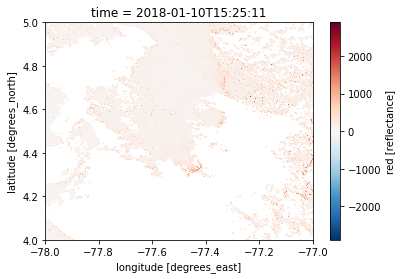

In [6]:
def cloud_mask(band_data_array,band_pixel_qa):
    """
    Enmascara o hace igual a NaN aquellos pixeles que no son 
    relevantes para el análisis, como aquellos pixeles donde se
    presentan nubes, nieve en todas sus modalidades.
    """
    
    nodata=-9999
    
    # VALORES VALIDOS PARA ANALISIS PRESENTES EN 
    # LA BANDA PIXEL_QA
    
    # Para este caso únicamente nos interesa conservar 
    # aquellos pixeles cuya obvercación es clara y 
    # además pixeles que pueden mostrar información 
    # acerca del agua
    clear = [322, 386, 834, 898, 1346]
    water = [324, 388, 836, 900, 1348]
    valid_values = clear + water

    # Aquellos pixeles cuyos valor esten en valid_values tendran un
    # valor de True en la corrspondiente posición en la matrix mask_1 
    # indicando que son pixeles validos para analisis. Aquellos pixeles 
    # cuyos valores no esten en valid_values tendran un valor de False 
    # en mask_1.
    mask_1 = np.isin(band_pixel_qa.values, valid_values)

    # Marca como True aquellos pixeles que tienen información, es decir, 
    # no son igual a nodata=-9999.
    has_information = band_data_array != nodata

    # Aquellos pixeles que tienen información (has_information[i][j] = True)
    # y son pixeles validos mask_1[i][j] = True, seguirán siendo válidos, es
    # decir, mask_2[i][j] = True. En caso contrarion mask_2[i][j] = False.
    mask_2 = np.logical_and(has_information,mask_1)

    # Para pixeles validos mask_2[i][j] = True, entonces 
    # new_band_data_array[i][j] = band_data_array[i][j]. 
    # En caso contrario, new_band_data_array[i][j] = NaN.
    new_band_data_array = np.where(mask_2,band_data_array,np.nan)
    return new_band_data_array


bands = ['blue','green','red','nir','swir1','swir2']
for band in bands:
    xarr[band].values = cloud_mask(
        band_data_array=xarr[band],
        band_pixel_qa=xarr['pixel_qa']
    )

    
# Los valores en blanco representan zonas donde los pixeles 
# tienen un valor de NaN (sin datos)
xarr.red.plot()

## NDVI Normalized Vegetation Index 

El Índice de Vegetación de Diferencia Normalizada (NDVI) cuantifica la vegetación midiendo la diferencia entre el infrarrojo cercano **nir** (que la vegetación refleja fuertemente) y la luz roja **red** (que la vegetación absorbe). NDVI siempre varía de -1 a +1. No hay un límite distinto para cada tipo de cobertura del suelo.

Valores del NDVI

* **Valores Negativos:** Es muy probable que sea agua.
* **Valores Cercanos a 1:** Existe una alta posibilidad de que sean hojas verdes densas.
* **Valores Cercanos a 0:** No hay hojas verdes e incluso podría ser un área urbanizada.

### Referencia

1. [What is NDVI (Normalized Difference Vegetation Index)?](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/)

/home/datacube/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/home/datacube/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less


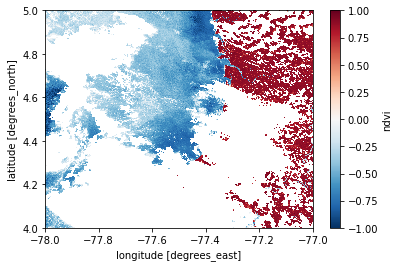

In [7]:
xarr0 = xarr.copy(deep=True)

# Eliminamos la dimensión tiempo dado que el 
# análisis únicamente comprende un slice de tiempo
xarr0 = xarr0.squeeze(['time'])

# Obteniendo los valores de las bandas. 
# los valores son np.array
period_red = xarr0["red"].values
period_nir = xarr0["nir"].values

# Si los pixeles en 'red' o 'nir' tiene valoes NaN entonces 
# mask_nan = True
mask_nan=np.logical_or(np.isnan(period_red), np.isnan(period_nir))

# NDVI computation
period_nvdi = (period_nir-period_red) / (period_nir+period_red)

# Remover pixeles invalidos
period_nvdi[mask_nan] = np.nan

# Remover valores mayores de 1 e inferiores a -1
# Ya que el indice está definido entre -1 y 1.
period_nvdi[period_nvdi>1] = np.nan
period_nvdi[period_nvdi<-1] = np.nan

# Convertir los datos obtenidos de np.array en un xarray.Dataset 
coords = dict(xarr0.coords)

# Eliminar la dimención tiempo ya que sólo estamos
# considerando una única toma en el tiempo
coords.pop('time',None)

# Obtener los nombres de las dimensiones en una lista
dims = dict(xarr0.dims)

# Eliminar la dimención tiempo ya que sólo estamos
# considerando una única toma en el tiempo
dims.pop('time',None)

data_array = xr.DataArray(data=period_nvdi,coords=coords, dims=dims)
data_set = xr.Dataset(data_vars={'ndvi':data_array}, attrs={'crs':xarr0.crs})

data_set.ndvi.plot()

## Bosque No Bosque

"La clasificación de Bosque/NoBosque utiliza como base del análisis de NDVI, sobre el cual el algoritmo recorre la imagen por una ventana definida por el usuario (p.e. 3x3, 1x1 pixeles), validando mediante un umbral dado por el usuario, cuales son los pixeles que pueden ser considerados como bosque y no bosque."

### Referencias

1. [bosque-no-bosque-wf_1.0.py ](https://github.com/OpenDatacubeIDEAM/cdcol-workflows/blob/master/algorithms/bosque-no-bosque-wf/bosque-no-bosque-wf_1.0.py)

/home/datacube/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


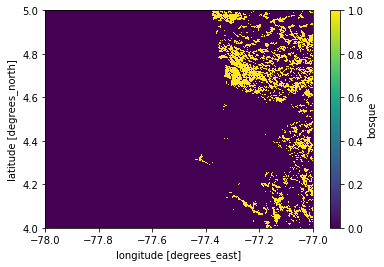

In [8]:
ndvi = data_set.ndvi.copy(deep=True)

# Dado que bosque no bosque es una clasificación
# binaria, los valores son número enteros 
# por lo tanto nodata no puede ser igual a NaN
nodata = -9999

nvdi_array = ndvi.values

# Umbral de Bosque
ndvi_threshold = 0.7

# Tasa de Vegetación 
vegetation_rate = 0.3

# Tamaño de Ventana
slice_size = 2

height = nvdi_array.shape[0]
width = nvdi_array.shape[1]
bosque_nobosque=np.full(nvdi_array.shape, -1)
for y1 in range(0, height, slice_size):
    for x1 in range(0, width, slice_size):
        x2 = x1 + slice_size
        y2 = y1 + slice_size
        if(x2 > width):
            x2 = width
        if(y2 > height):
            y2 = height
        submatrix = nvdi_array[y1:y2,x1:x2]
        ok_pixels = np.count_nonzero(~np.isnan(submatrix))
        if ok_pixels==0:
            bosque_nobosque[y1:y2,x1:x2] = nodata
        elif np.nansum(submatrix>ndvi_threshold)/ok_pixels >= vegetation_rate :
            bosque_nobosque[y1:y2,x1:x2] = 1
        else:
            bosque_nobosque[y1:y2,x1:x2] = 0

# Los valores que son iguales a nodata=-9999 los 
# los convertimos a 0 (no bosque)
mask_nan=np.isin(bosque_nobosque,[nodata])
bosque_nobosque[mask_nan] = 0

# Convertir los datos obtenidos de np.array en un xarray.Dataset 
coords = dict(data_set.coords)

# Eliminar la dimención tiempo ya que sólo estamos
# considerando una única toma en el tiempo
coords.pop('time',None)

# Obtener los nombres de las dimensiones en una lista
dims = dict(data_set.dims)

# Eliminar la dimención tiempo ya que sólo estamos
# considerando una única toma en el tiempo
dims.pop('time',None)

data_array_bosque = xr.DataArray(data=bosque_nobosque,coords=coords, dims=dims)
data_set_boque = xr.Dataset(data_vars={'bosque':data_array_bosque}, attrs={'crs':xarr0.crs})

data_set_boque.bosque.plot()

## Water Observation from Space

"El algoritmo de clasificación WOFS (Water Observations from Space), permite una clasificación de Agua/noAgua  usando un árbol de regresión entrenado para la clasificación de la cobertura de agua a lo largo de un periodo de tiempo. Las salidas del algoritmo WOFS incluyen observaciones de clasificación de agua a nivel de píxeles estáticos para cada periodo evaluado, y de series de tiempo para cualquier píxel dentro de una misma zona."

### References

1. [Cubo de Datos de Imágenes de Satelite de Colombia - IDEAM](http://cdcol.ideam.gov.co/)
2. [Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia](https://www.sciencedirect.com/science/article/pii/S0034425715301929)

In [14]:
def wofs_classify(dataset_in, clean_mask=None, no_data=-9999, enforce_float64=False):
    """
    Description:
      Performs WOfS algorithm on given dataset. If no clean mask is given, the 'cf_mask'
      variable must be included in the input dataset, as it will be used to create a 
      clean mask
    Assumption:
      - The WOfS algorithm is defined for Landsat 5/Landsat 7 
    References:
      - Mueller, et al. (2015) "Water observations from space: Mapping surface water from 
        25 years of Landsat imagery across Australia." Remote Sensing of Environment.
      - https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py
    -----
    Inputs:
      dataset_in (xarray.Dataset) - dataset retrieved from the Data Cube; should contain
        coordinates: time, latitude, longitude
        variables: blue, green, red, nir, swir1, swir2
        If user does not provide a clean_mask, dataset_in must also include the cf_mask
        variable
    Optional Inputs:
      clean_mask (nd numpy array with dtype boolean) - true for values user considers clean;
        if user does not provide a clean mask, one will be created using cfmask
      no_data (int/float) - no data pixel value; default: -9999
      enforce_float64 (boolean) - flag to indicate whether or not to enforce float64 calculations;
        will use float32 if false
    Output:
      dataset_out (xarray.DataArray) - wofs water classification results: 0 - not water; 1 - water
    """
    
    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)
        
    def _run_regression(band1, band2, band3, band4, band5, band7):
        """
        Regression analysis based on Australia's training data
        TODO: Return type
        """
        
        # Compute normalized ratio indices
        ndi_52 = _band_ratio(band5, band2)
        ndi_43 = _band_ratio(band4, band3)
        ndi_72 = _band_ratio(band7, band2)
        
        #classified = np.ones(shape, dtype='uint8')
        
        classified = np.full(shape, no_data)
      
        # Start with the tree's left branch, finishing nodes as needed
        
        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = band1 <= 2083.5
        classified[r1 & ~r2] = 0 #Node 3

        r3 = band7 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1 #Node 6
        classified[_tmp2 & ~r4] = 0 #Node 7

        r5 = band1 <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1 #Node 10
        classified[_tmp2 & ~r6] = 0 #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = band1 <= 379
        classified[_tmp2 & r8] = 1 #Node 14
        classified[_tmp2 & ~r8] = 0 #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1 #Node 17
        _tmp &= ~r9

        r10 = band1 <= 473
        classified[_tmp & r10] = 1 #Node 19
        classified[_tmp & ~r10] = 0 #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()
        
        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = band1 <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0 #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0 #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1 #Node 27

        _tmp &= ~r14

        r15 = band3 <= 364.5
        _tmp2 = _tmp & r15

        r16 = band1 <= 129.5
        classified[_tmp2 & r16] = 1 #Node 31
        classified[_tmp2 & ~r16] = 0 #Node 32

        _tmp &= ~r15

        r17 = band1 <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1 #Node 33
        classified[_tmp2] = 0 #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0 #Node 36
        _tmp &= r18

        r19 = band1 <= 249.5
        classified[_tmp & ~r19] = 0 #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0 #Node 40
        _tmp &= r20

        r21 = band3 <= 364.5
        classified[_tmp & ~r21] = 0 #Node 42
        _tmp &= r21

        r22 = band1 <= 129.5
        classified[_tmp & r22] = 1 #Node 44
        classified[_tmp & ~r22] = 0 #Node 45

        # Completed regression tree
        
        return classified
    
    # Extract dataset bands needed for calculations
    blue = dataset_in.blue
    green = dataset_in.green
    red = dataset_in.red
    nir = dataset_in.nir
    swir1 = dataset_in.swir1
    swir2 = dataset_in.swir2
    
    # Create a clean mask from cfmask if the user does not provide one
    if not clean_mask:
        cfmask = dataset_in.pixel_qa
        clean_mask = create_cfmask_clean_mask(cfmask)
    
    # Enforce float calculations - float64 if user specified, otherwise float32 will do
    dtype = blue.values.dtype # This assumes all dataset bands will have
                              # the same dtype (should be a reasonable
                              # assumption)

    if enforce_float64:
        if dtype != 'float64':
            blue.values = blue.values.astype('float64')
            green.values = green.values.astype('float64')
            red.values = red.values.astype('float64')
            nir.values = nir.values.astype('float64')
            swir1.values = swir1.values.astype('float64')
            swir2.values = swir2.values.astype('float64')
    else:
        if dtype == 'float64':
            pass
        elif dtype != 'float32':
            blue.values = blue.values.astype('float32')
            green.values = green.values.astype('float32')
            red.values = red.values.astype('float32')
            nir.values = nir.values.astype('float32')
            swir1.values = swir1.values.astype('float32')
            swir2.values = swir2.values.astype('float32')
    
    shape = blue.values.shape
    classified = _run_regression(blue.values, green.values, red.values, 
                                 nir.values, swir1.values, swir2.values)

    classified_clean = np.full(classified.shape, no_data)
    classified_clean[clean_mask] = classified[clean_mask] # Contains data for clear pixels
    
    # Create xarray of data
    time = dataset_in.time
    if hasattr(dataset_in,'latitude'):
        latitude = dataset_in.latitude 
        longitude = dataset_in.longitude 
    
        data_array = xr.DataArray(classified_clean,
                              coords=[time, latitude, longitude],
                              dims=['time', 'latitude', 'longitude'])
    
        dataset_out = xr.Dataset({'wofs': data_array},
                             coords={'time': time,
                                     'latitude': latitude,
                                     'longitude': longitude})
    else:
        y = dataset_in.y 
        x = dataset_in.x
        data_array = xr.DataArray(classified_clean,
                              coords=[time, y, x],
                              dims=['time', 'y', 'x'])
    
        dataset_out = xr.Dataset({'wofs': data_array},
                             coords={'time': time,
                                     'y': y,
                                     'x': x})
                                     
    return dataset_out

def create_cfmask_clean_mask(cfmask):
    """
    Description:
      Create a clean mask for clear land/water pixels,
      i.e. mask out shadow, snow, cloud, and no data
    -----
    Input:
      cfmask (xarray) - cf_mask from the ledaps products
    Output:
      clean_mask (boolean numpy array) - clear land/water mask
    """

    #########################
    # cfmask values:        #
    #   0 - clear           #
    #   1 - water           #
    #   2 - cloud shadow    #
    #   3 - snow            #
    #   4 - cloud           #
    #   255 - fill          #
    #########################

    clean_mask = np.reshape(np.in1d(cfmask.values.reshape(-1), [2, 3, 4, 255], invert=True),
                            cfmask.values.shape)
    return clean_mask

def get_spatial_ref(crs):
    """
    Description:
      Get the spatial reference of a given crs
    -----
    Input:
      crs (datacube.model.CRS) - Example: CRS('EPSG:4326')
    Output:
      ref (str) - spatial reference of given crs
    """

    crs_str = str(crs)
    epsg_code = int(crs_str.split(':')[1])
    ref = osr.SpatialReference()
    ref.ImportFromEPSG(epsg_code)
    return str(ref)

def perform_timeseries_analysis(dataset_in, no_data=-9999):
    """
    Description:

    -----
    Input:
      dataset_in (xarray.DataSet) - dataset with one variable to perform timeseries on
    Output:
      dataset_out (xarray.DataSet) - dataset containing 
        variables: normalized_data, total_data, total_clean
    """
    
    data_vars = dataset_in.data_vars
    #key = data_vars.keys()[0]
    key = "wofs"
    
    data = data_vars[key]

    #shape = data.shape[1:]

    data_dup = data.copy(deep=True)
    data_dup.values = data_dup.values.astype('float')
    data_dup.values[data.values == no_data] = 0

    processed_data_sum = data_dup.sum('time')
    # Masking no data values then converting boolean to int for easy summation
    clean_data_raw = np.reshape(np.in1d(data.values.reshape(-1), [no_data], invert=True),
                                        data.values.shape).astype(int)
    # Create xarray of data
    time = data.time

    if hasattr(data, "latitude"):
        latitude = data.latitude
        longitude = data.longitude
        clean_data = xr.DataArray(clean_data_raw,
                              coords=[time, latitude, longitude],
                              dims=['time', 'latitude', 'longitude'])
    else:
        y = data.y
        x = data.x
        clean_data = xr.DataArray(clean_data_raw,coords=[time, y, x],dims=['time', 'y', 'x'])
   

    clean_data_sum = clean_data.sum('time')

    processed_data_normalized = processed_data_sum/clean_data_sum
    if hasattr(data, "latitude"):
        dataset_out = xr.Dataset(collections.OrderedDict([('normalized_data', (['latitude', 'longitude'], processed_data_normalized)),
                                                      ('total_data', (['latitude', 'longitude'], processed_data_sum)),
                                                      ('total_clean', (['latitude', 'longitude'], clean_data_sum))]),
                             coords={'latitude': latitude,
                                     'longitude': longitude})
    else:
        dataset_out = xr.Dataset(collections.OrderedDict([('normalized_data', (['y', 'x'], processed_data_normalized)),
                                                      ('total_data', (['y', 'x'], processed_data_sum)),
                                                      ('total_clean', (['y', 'x'], clean_data_sum))]),
                             coords={'y': y,
                                     'x': x})
    return dataset_out

/home/datacube/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less_equal
/home/datacube/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less_equal
/home/datacube/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less_equal
/home/datacube/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/datacube/.local/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in less_equal
/home/datacube/.local/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less_equal
/home/datacube/.local/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in less_equal
/home/datacube/.local/lib/python3.6/site-packages/ipykernel_launcher.py:80: 

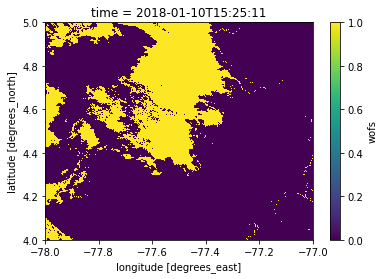

In [15]:
xarr3 = xarr.copy(deep=True)
output = wofs_classify(xarr3)
output.wofs[0].plot()
